In [1]:
! nvidia-smi

Fri May 19 00:17:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# TFIDF + Random Forest model
We will directly use the TFIDF and Random Forest models of the sklearn library. 
In addition, the nltk library is used to preprocess text data into standard form before it is input to vectorize through the TFIDF model.

## 1. General Settings
Install some necessary libraries and download processed data for model training and evaluation

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import re
import string
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Data Preprocessing
To process text data, we need to go through the following steps:
* Convert all uppercase characters to lowercase
* Remove all characters except the characters from a-z, A-Z, 0-9, !,...
* Remove all punctuation marks in text to empty characters
* Remove all stop words, which are words that appear a lot but do not play an important role in meaning with the text
* Put all words into one format (lemmatizer)

In [2]:
def get_stopwords_list(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [3]:
stopwords_path = "C:\\Users\\DELL\\Programming\\python\\StockReview.IntroAI.20222\\source\\data\\vietnamese_stopwords.txt"
sw = get_stopwords_list(stopwords_path)
lemmatizer = WordNetLemmatizer()
sw

['tin thêm',
 'đến cùng',
 'nói riêng',
 'từ thế',
 'ba',
 'thay đổi',
 'đến giờ',
 'gì',
 'trong lúc',
 'trước nay',
 'bán thế',
 'nói nhỏ',
 'không ai',
 'đưa cho',
 'phỏng nước',
 'rõ thật',
 'thỉnh thoảng',
 'nhất sinh',
 'là cùng',
 'nói',
 'chỉ có',
 'bộ',
 'làm như',
 'dễ đâu',
 'thường thường',
 'nhà đầu tư',
 'nhờ có',
 'cùng với',
 'qua tay',
 'đầu tư',
 'cao thế',
 'cả nghe',
 'sau hết',
 'dữ cách',
 'khá',
 'kể từ',
 'lấy có',
 'thiếu điểm',
 'thím',
 'có chăng',
 'bởi thế',
 'trếu tráo',
 'thoắt',
 'từ khi',
 'cả người',
 'suýt',
 'hiểu',
 'dạ khách',
 'xin',
 'lớn lên',
 'bỗng nhiên',
 'không hay',
 'ừ ừ',
 'bước đi',
 'nói rõ',
 'thường số',
 'cao số',
 'xăm xắm',
 'nhà chung',
 'bản ý',
 'về sau',
 'gần bên',
 'một',
 'đưa tin',
 'ngôi',
 'chung qui',
 'chị',
 'bây nhiêu',
 'suýt nữa',
 'tuy thế',
 'còn',
 'cùng chung',
 'tăng thế',
 'bài bỏ',
 'có người',
 'nhưng',
 'phần lớn',
 'ít quá',
 'nhờ nhờ',
 'biết đâu chừng',
 'chớ chi',
 'ngay cả',
 'đến thì',
 'lấy thế',
 '

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿0-9]+", " ", text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,_' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

## 3. Modelling and Evaluation

### 3.1. Modelling (TFIDF + Random Forest)
Workflow: Preprocessing -> Vectorization (using TFIDF model) -> Using RF model -> Print evaluation.
* Preprocessor: Use the preprocessor function implemented above.
* Vectorization: Use the TFIDF model to convert texts to vectors.
* Use the Random Forest model.
* Evaluation: We will use sklearn's classification method to print out the f1_score, accuracy of each class. The confusion matrix will then be printed based on the predicted results and the actual results. 

In [5]:
from sklearn.metrics import accuracy_score

class Model(object):
    def __init__(self):
        f = open('data/stock_train.json', encoding='utf-8')
        self.data_train = json.load(f)
        f.close()
        f = open('data/stock_test.json', encoding='utf-8')
        self.data_test = json.load(f)
        f.close()
        self.train = []
        self.label_train = []
        self.test = []
        self.label_test = []
        self.feature_names = []
        self.predict = None
        self.train_accuracy = None
        self.test_accuracy = None
        
    def PreProcessing(self):
        for data in self.data_train:
            self.train.append(clean_text(data['text']))
            self.label_train.append(data['label'])
        for data in self.data_test:
            self.test.append(clean_text(data['text']))
            self.label_test.append(data['label'])
        
    def Vectorizer(self):
        self.tfidf_vectorizer = TfidfVectorizer(smooth_idf=False)
        self.tfidf_train_vectors = self.tfidf_vectorizer.fit_transform(self.train)
        self.tfidf_test_vectors = self.tfidf_vectorizer.transform(self.test)
        self.feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
    def Run(self):
        self.PreProcessing()
        self.Vectorizer()
        self.classifier = RandomForestClassifier()
        self.classifier.fit(self.tfidf_train_vectors, self.label_train)
        self.predict = self.classifier.predict(self.tfidf_test_vectors)
        print(classification_report(self.label_test, self.predict))
        
        self.test_accuracy = accuracy_score(self.label_test, self.predict)
        
        train_predictions = self.classifier.predict(self.tfidf_train_vectors)
        self.train_accuracy = accuracy_score(self.label_train, train_predictions)
        
        print(f"Train Accuracy: {self.train_accuracy}")
        print(f"Test Accuracy: {self.test_accuracy}")
        
        cm = confusion_matrix(self.label_test, self.predict)
        _display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.classifier.classes_)
        _display.plot()
        plt.show()

### 3.2. Evaluation

              precision    recall  f1-score   support

    negative       0.49      0.48      0.48       323
     neutral       0.49      0.53      0.51       321
    positive       0.51      0.48      0.49       358

    accuracy                           0.50      1002
   macro avg       0.50      0.50      0.50      1002
weighted avg       0.50      0.50      0.50      1002

Train Accuracy: 0.9953825857519789
Test Accuracy: 0.49600798403193613


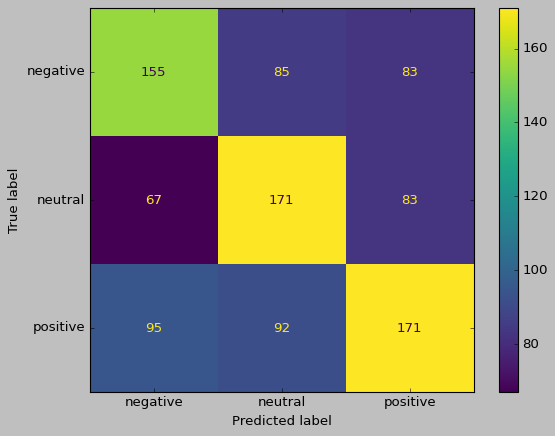

In [6]:
t = Model()
t.Run()